In [1]:
#  Import necessary packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.patches import Ellipse

In [2]:
FILES = ['classificationA.train', 'classificationA.test',
         'classificationB.train', 'classificationB.test',
         'classificationC.train', 'classificationC.test']

In [3]:
CONFIG = {'A': {'DS': 'A', 'TRAIN': FILES[0], 'TEST': FILES[1]},
          'B': {'DS': 'B', 'TRAIN': FILES[2], 'TEST': FILES[3]},
          'C': {'DS': 'C', 'TRAIN': FILES[4], 'TEST': FILES[5]}}

In [4]:
CONFIG = CONFIG['A']  # Chose which dataset you want to run the analysis on
STOPPING = 0.001  # stopping criterion for IRLS

In [5]:
# Initialize tensorflow variables
test = tf.placeholder(dtype=tf.float32, shape=[None, 3,])
train = tf.placeholder(dtype=tf.float32, shape=[None, 3,])
pi_mle = tf.Variable(initial_value=0, dtype=tf.float32)
mu_0_mle = tf.Variable(initial_value=[0,0], dtype=tf.float32)
mu_1_mle = tf.Variable(initial_value=[0,0], dtype=tf.float32)
sigma_mle = tf.Variable(initial_value=[[0,0], [0,0]], dtype=tf.float32)
sigma_mle_1 = tf.Variable(initial_value=[[0,0], [0,0]], dtype=tf.float32)
sigma_mle_2 = tf.Variable(initial_value=[[0,0], [0,0]], dtype=tf.float32)

In [6]:
#  Compute pi MLE for MoG
pi_mle = pi_mle.assign(tf.reduce_mean(train, axis=0)[2])

In [7]:
#  Compute mu MLE for MoG
group_1 = tf.squeeze(tf.gather(train[:,0:2], indices=tf.where(condition=tf.equal(train[:, 2],0))))
mu_0_mle = mu_0_mle.assign(tf.reduce_mean(group_1, axis=0))
group_2 = tf.squeeze(tf.gather(train[:,0:2], indices=tf.where(condition=tf.equal(train[:, 2],1))))
mu_1_mle = mu_1_mle.assign(tf.reduce_mean(group_2, axis=0))

In [8]:
#  Compute Sigma MLE for MoG
size_1 = tf.cast(tf.shape(group_1)[0], tf.float32)
sigma_mle_1 = sigma_mle_1.assign(tf.matmul(tf.transpose(group_1), group_1)/size_1)
sigma_mle_1 -= [[mu_0_mle[0]**2, mu_0_mle[0]*mu_0_mle[1]],
                 [mu_0_mle[0]*mu_0_mle[1], mu_0_mle[1]**2]]
size_2 = tf.cast(tf.shape(group_2)[0], tf.float32)
sigma_mle_2 = sigma_mle_2.assign(tf.matmul(tf.transpose(group_2), group_2)/size_2)
sigma_mle_2 -= [[mu_1_mle[0]**2, mu_1_mle[0]*mu_1_mle[1]],
                 [mu_1_mle[0]*mu_1_mle[1], mu_1_mle[1]**2]]
sigma_mle = sigma_mle.assign((size_1/(size_1+size_2))*sigma_mle_1 + (size_1/(size_1+size_2))*sigma_mle_2)

In [9]:
#  Logistic Regression OPs
train_labels = tf.placeholder(dtype=tf.float32, shape=[None, 1,])
logistic_weights = tf.Variable(initial_value=tf.random_uniform(shape=[3, 1]), dtype=tf.float32)

mu = tf.sigmoid(tf.matmul(train, logistic_weights))
D = tf.diag(tf.squeeze(tf.add(1.0, -mu)))
logistic_update = tf.matrix_inverse(tf.matmul(tf.matmul(tf.transpose(train), D), train))
logistic_update = tf.matmul(tf.matmul(logistic_update, tf.transpose(train)), tf.add(mu, -train_labels))
logistic_train_op = logistic_weights.assign(tf.add(logistic_weights,-logistic_update))

In [10]:
init_op = tf.global_variables_initializer()

In [11]:
#  Linear Regression OPs
linear_weights = tf.Variable(initial_value=tf.random_uniform(shape=[3, 1]), dtype=tf.float32)
linear_train_op = linear_weights.assign(
    tf.matmul(
        tf.matmul(tf.matrix_inverse(tf.matmul(tf.transpose(train), train)), tf.transpose(train)),
        train_labels)
    )

In [13]:
#  Do computations in Tensorflow!
with tf.Session() as sess:
    train_data = pd.read_table('hwk2data/' + CONFIG['TRAIN'], header=None)
    test_data = pd.read_table('hwk2data/' + CONFIG['TEST'], header=None)
    sess.run(init_op)

    #  Q1 TF comps
    pi_mle, mu_0_mle, mu_1_mle, \
    sigma_mle, sigma_mle_1, sigma_mle_2 = sess.run([pi_mle, mu_0_mle, mu_1_mle, sigma_mle, sigma_mle_1, sigma_mle_2],
                                                   feed_dict={train: train_data, test: test_data})

    #  Q2 TF comps
    train_data[3] = [1] * train_data.shape[0]

    logistic_weights = sess.run(logistic_train_op, feed_dict={train: train_data[[0, 1, 3]],
                                                              train_labels: train_data[[2]]})
    previous_weights = np.array([0, 0, 0])

    step = 1
    while np.linalg.norm(logistic_weights.flatten()-previous_weights) > STOPPING:  # Stopping criterion
        previous_weights = logistic_weights.flatten()
        logistic_weights = sess.run(logistic_train_op, feed_dict={train: train_data[[0, 1, 3]],
                                                                  train_labels: train_data[[2]]})
        #print('Updating weights for separating plane, step {} ...'.format(step))
        step += 1
        #print('Norm of change in weights ...')
        #print(np.linalg.norm(logistic_weights.flatten()-previous_weights))

    #  Q3 TF comps
    linear_weights = sess.run(linear_train_op, feed_dict={train: train_data[[0, 1, 3]],
                                                          train_labels: train_data[[2]]})

In [14]:
#########################################################
#################### Question 1 C #######################
#########################################################

#  Implementing MLE for Mixture of Gaussians with shared Covariance to each Dataset.

#  Compute seperating plane
m_0 = -np.dot(np.transpose(mu_0_mle), np.linalg.inv(sigma_mle))
m_1 = -np.dot(np.transpose(mu_1_mle), np.linalg.inv(sigma_mle))
b_0 = -0.5*np.dot(m_0, mu_0_mle) + np.log(1-pi_mle)
b_1 = -0.5*np.dot(m_1, mu_1_mle) + np.log(pi_mle)
print("Weights for LDA seperating line: ",(m_0-m_1)[0],(m_0-m_1)[1], b_0-b_1)

Weights for LDA seperating line:  -5.30848 -7.76482 1.13555264776


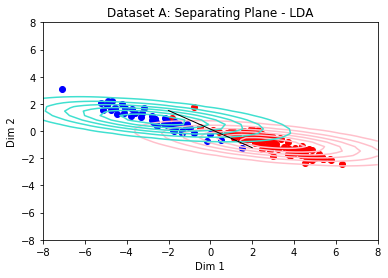

In [15]:
def line(x):
    return -(b_0-b_1 + (m_0[0]-m_1[0])*x)/(m_0[1]-m_1[1])

#  Plot data points
plt.figure()
plt.scatter(x=train_data[train_data[2] == 0][0], y=train_data[train_data[2] == 0][1], color='red')
plt.scatter(x=train_data[train_data[2] == 1][0], y=train_data[train_data[2] == 1][1], color='blue')

#  Overlay with contours of Normal Dist.
x = np.linspace(-8, 8)
y = np.linspace(-8, 8)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, sigmax=sigma_mle[0,0], sigmay=sigma_mle[1,1],
                           mux=mu_0_mle[0], muy=mu_0_mle[1], sigmaxy=sigma_mle[1,0])
Z2 = mlab.bivariate_normal(X, Y, sigmax=sigma_mle[0,0], sigmay=sigma_mle[1,1],
                           mux=mu_1_mle[0], muy=mu_1_mle[1], sigmaxy=sigma_mle[1,0])
plt.contour(X, Y, Z1, colors='pink')
plt.contour(X, Y, Z2, colors='turquoise')

x = np.linspace(-2, 2)
plt.plot(x, line(x), 'k-', linewidth=1)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('Dataset {}: Separating Plane - LDA'.format(CONFIG['DS']))
#plt.savefig('../img_{}_MoG'.format(CONFIG['DS'])) # to save figure
plt.show()

In [16]:
#  Compute error rate
def get_error_rate(w_1,w_2, b, X_0, X_1, Y):
    tp = np.logical_and(np.add(w_1*X_0, w_2*X_1) + b > 0, Y == 1)
    tn = np.logical_and(np.add(w_1 * X_0, w_2 * X_1) + b < 0, Y == 0)
    error_rate = 1 - (np.sum(tp)+np.sum(tn))/X_0.shape[0]
    return(error_rate)

train_rate = get_error_rate(w_1=(m_0 - m_1)[0], w_2=(m_0 - m_1)[1], b=(b_0-b_1),
                            X_0=train_data[[0]], X_1=train_data[[1]], Y=train_data[[2]])
print('MoG Training rate: {}'.format(round(train_rate[0],4)))

test_rate = get_error_rate(w_1=(m_0 - m_1)[0], w_2=(m_0 - m_1)[1], b=(b_0-b_1),
                           X_0=test_data[[0]], X_1=test_data[[1]], Y=test_data[[2]])
print('MoG Testing rate: {}'.format(round(test_rate[0],4)))

MoG Training rate: 0.0133
MoG Testing rate: 0.0353


In [17]:
#######################################################
#################### Question 2 #######################
#######################################################

#  Implementing Logistic Regression to each Dataset.
print("Weights for Logistic Regression: ", logistic_weights.flatten().tolist())

Weights for Logistic Regression:  [-11.49156379699707, -19.205324172973633, -2.0470778942108154]


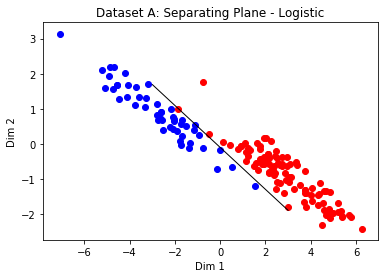

In [18]:
def line(x):
    return -(logistic_weights[2] + (logistic_weights[0])*x)/(logistic_weights[1])

#  Plot data points and seperating plane
plt.figure()
plt.scatter(x=train_data[train_data[2] == 0][0], y=train_data[train_data[2] == 0][1], color='red')
plt.scatter(x=train_data[train_data[2] == 1][0], y=train_data[train_data[2] == 1][1], color='blue')

x = np.linspace(-3, 3)
plt.plot(x, line(x), 'k-', linewidth=1)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('Dataset {}: Separating Plane - Logistic'.format(CONFIG['DS']))

#plt.savefig('../img_{}_Log'.format(CONFIG['DS']))
plt.show()

In [19]:
train_rate = get_error_rate(w_1=logistic_weights[0], w_2=logistic_weights[1], b=logistic_weights[2],
                            X_0=train_data[[0]], X_1=train_data[[1]], Y=train_data[[2]])
print('Logistic Training rate: {}'.format(round(train_rate[0],4)))

test_rate = get_error_rate(w_1=logistic_weights[0], w_2=logistic_weights[1], b=logistic_weights[2],
                           X_0=test_data[[0]], X_1=test_data[[1]], Y=test_data[[2]])
print('Logistic Testing rate: {}'.format(round(test_rate[0],4)))

Logistic Training rate: 0.0067
Logistic Testing rate: 0.0293


In [20]:
#######################################################
#################### Question 3 #######################
#######################################################

#  See Linear Regression weights for Dataset.
print("Weights for Linear Regression: ", linear_weights.flatten().tolist())

Weights for Linear Regression:  [-0.2640095353126526, -0.3725985884666443, 0.49229252338409424]


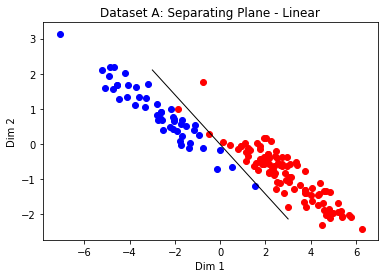

In [21]:
def line(x):
    return (0.5 - linear_weights[2] - (linear_weights[0])*x)/(linear_weights[1])

#  Plot data points and seperating plane
plt.figure()
plt.scatter(x=train_data[train_data[2] == 0][0], y=train_data[train_data[2] == 0][1], color='red')
plt.scatter(x=train_data[train_data[2] == 1][0], y=train_data[train_data[2] == 1][1], color='blue')

x = np.linspace(-3, 3)
plt.plot(x, line(x), 'k-', linewidth=1)
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('Dataset {}: Separating Plane - Linear'.format(CONFIG['DS']))

#plt.savefig('../img_{}_Lin'.format(CONFIG['DS']))
plt.show()

In [22]:
#  Compute error rate
def get_error_rate(w_1,w_2, b, X_0, X_1, Y):
    tp = np.logical_and(np.add(w_1*X_0, w_2*X_1) + b > 0.5, Y == 1)
    tn = np.logical_and(np.add(w_1 * X_0, w_2 * X_1) + b < 0.5, Y == 0)
    error_rate = 1 - ((np.sum(tp)+np.sum(tn))/X_0.shape[0])
    return(error_rate)

train_rate = get_error_rate(w_1=linear_weights[0], w_2=linear_weights[1], b=linear_weights[2],
                            X_0=train_data[[0]], X_1=train_data[[1]], Y=train_data[[2]])
print('LR Training rate: {}'.format(round(train_rate[0], 4)))

test_rate = get_error_rate(w_1=linear_weights[0], w_2=linear_weights[1], b=linear_weights[2],
                           X_0=test_data[[0]], X_1=test_data[[1]], Y=test_data[[2]])
print('LR Testing rate: {}'.format(round(test_rate[0], 4)))

LR Training rate: 0.0133
LR Testing rate: 0.0207


In [23]:
#######################################################
#################### Question 5 #######################
#######################################################

#  Compute seperating plane
s_mle_inv_1 = np.linalg.inv(sigma_mle_1)
s_mle_inv_2 = np.linalg.inv(sigma_mle_2)
b = 0.5*np.log(np.linalg.det(sigma_mle_2)/np.linalg.det(sigma_mle_1)) + np.log(pi_mle/(1-pi_mle)) \
    - 0.5*np.dot(np.dot(np.transpose(mu_0_mle), s_mle_inv_1),mu_0_mle) \
    + 0.5*np.dot(np.dot(np.transpose(mu_1_mle), s_mle_inv_2),mu_1_mle)

m_x = np.dot(s_mle_inv_1, mu_0_mle)[0] - np.dot(s_mle_inv_2, mu_1_mle)[0]
m_y = np.dot(s_mle_inv_1, mu_0_mle)[1] - np.dot(s_mle_inv_2, mu_1_mle)[1]

m_x2 = -0.5*s_mle_inv_1[0,0] + 0.5*s_mle_inv_2[0,0]
m_xy = -s_mle_inv_1[0,1] + s_mle_inv_2[0,1]
m_y2 = -0.5*s_mle_inv_1[1,1] +0.5*s_mle_inv_2[1,1]

print("Weights for QDA seperating line: ", m_x, m_y, m_x2, m_xy, m_y2, b)

Weights for QDA seperating line:  7.36524 10.8733 0.75874209404 3.02731 2.86173391342 -0.759995726827


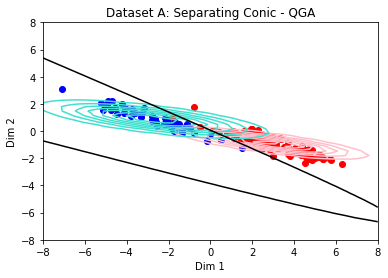

In [24]:
#  Plot data points
plt.figure()
plt.scatter(x=train_data[train_data[2] == 0][0], y=train_data[train_data[2] == 0][1], color='red')
plt.scatter(x=train_data[train_data[2] == 1][0], y=train_data[train_data[2] == 1][1], color='blue')

#  Overlay with contours of Normal Dist.
x = np.linspace(-8, 8)
y = np.linspace(-8, 8)
x, y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, sigmax=sigma_mle_1[0,0], sigmay=sigma_mle_1[1,1],
                           mux=mu_0_mle[0], muy=mu_0_mle[1], sigmaxy=sigma_mle_1[1,0])
Z2 = mlab.bivariate_normal(X, Y, sigmax=sigma_mle_2[0,0], sigmay=sigma_mle_2[1,1],
                           mux=mu_1_mle[0], muy=mu_1_mle[1], sigmaxy=sigma_mle_2[1,0])
plt.contour(X, Y, Z1, colors='pink')
plt.contour(X, Y, Z2, colors='turquoise')

#  Plot seperating conic
plt.contour(x, y, (x*m_x + y*m_y + m_x2*x**2 + m_xy*x*y + m_y2*y**2 + b), [0], colors='k')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('Dataset {}: Separating Conic - QGA'.format(CONFIG['DS']))
#plt.savefig('../img_{}_MoG_dm'.format(CONFIG['DS']))
plt.show()

In [25]:
#  Print learned parameters
print('The learned parameters are:')
print('pi: {0} \n mean 1: {1} \n mean 2: {2} \n Sigma 1: {3} \n Sigma 2: {4}'
      .format(pi_mle, mu_0_mle, mu_1_mle, sigma_mle_1, sigma_mle_2))

The learned parameters are:
pi: 0.3333333432674408 
 mean 1: [ 2.89970922 -0.89387399] 
 mean 2: [-2.69231987  0.86604202] 
 Sigma 1: [[ 2.3106575  -1.0474844 ]
 [-1.0474844   0.57578403]] 
 Sigma 2: [[ 2.70442057 -1.30085158]
 [-1.30085158  0.68969613]]


In [26]:
#  Compute error rate
def get_error_rate(X_0, X_1, Y):
    tp = np.logical_and(
        np.add(np.add(np.add(np.add(np.add(X_0*m_x, X_1*m_y), m_x2*X_0**2),
                             m_xy*np.multiply(X_0, X_1)), m_y2*X_1**2), b) < 0, Y == 1)
    tn = np.logical_and(
        np.add(np.add(np.add(np.add(np.add(X_0*m_x, X_1*m_y), m_x2*X_0**2),
                             m_xy*np.multiply(X_0,X_1)), m_y2*X_1**2), b) > 0, Y == 0)
    error_rate = 1 - ((np.sum(tp)+np.sum(tn))/X_0.shape[0])
    return(error_rate)

train_rate = get_error_rate(X_0=train_data[[0]], X_1=train_data[[1]], Y=train_data[[2]])
print('QDA Training rate: {}'.format(round(train_rate[0],4)))

test_rate = get_error_rate(X_0=test_data[[0]], X_1=test_data[[1]], Y=test_data[[2]])
print('QDA Testing rate: {}'.format(round(test_rate[0],4)))

QDA Training rate: 0.0133
QDA Testing rate: 0.0273
